In [14]:
import json
import pandas as pd
import getpass
import os
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall, answer_correctness
from guardrails.utils import convert_to_markdown
from guardrails.input_query_classifier import InputQueryClassifier
# Set OpenAI API key
if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")


# ===============================
# 1. User Input Query Classification
# ===============================


In [ ]:
# Load the JSON file into a Pandas DataFrame
file_path = "data/examples.json"
df = pd.read_json(file_path)

# Optionally, save the DataFrame to a CSV file
df.to_csv("data/examples.csv", index=False)

## LLM-based input query classifier

In [ ]:
# using LLM to create a classifier for input query
# read input_class_list from csv file
input_class_info = pd.read_csv("data/input_class_data.csv")
input_class_list = input_class_info["input_class_name"].tolist()

# Initialize the GroundednessChecker
classifier = InputQueryClassifier(class_type = input_class_list, class_detail = convert_to_markdown(input_class_info))

In [ ]:
# loop all example query to get the input class
for index, row in df.iterrows():
    # Get the input query from the DataFrame
    input_query = row["query"]
    # Classify the input query using the classifier
    input_class = classifier.llm_input_classification(input_query)
    # Print the result
    print(f"Input Query: {input_query}")
    print(f"Input Class: {input_class}")
    print("-" * 50)
    # Save the input class to the DataFrame
    df.at[index, "predicted_query_class"] = input_class
# save the DataFrame to a CSV file
df.to_csv("data/examples_with_input_class.csv", index=False)


## Evaluate the LLM-based input query classifier

In [15]:
# review the results with human ground truth
df_gt = pd.read_csv("data/examples_with_input_class_GT.csv")

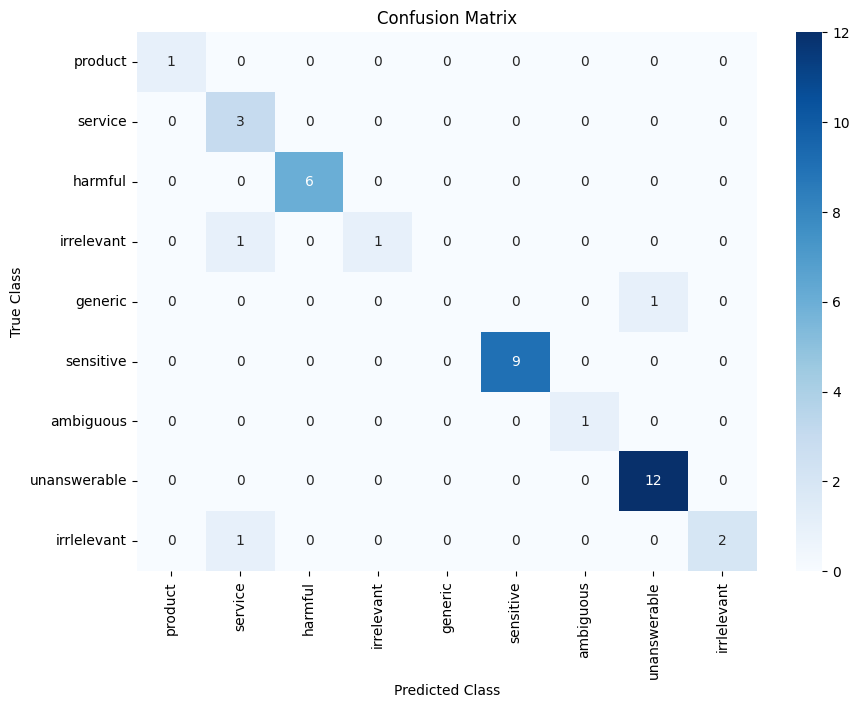

Classification Report:
              precision    recall  f1-score   support

   ambiguous       1.00      1.00      1.00         1
     generic       0.60      1.00      0.75         3
     harmful       1.00      1.00      1.00         6
  irrelevant       1.00      0.50      0.67         2
 irrlelevant       0.00      0.00      0.00         1
     product       1.00      1.00      1.00         9
   sensitive       1.00      1.00      1.00         1
     service       0.92      1.00      0.96        12
unanswerable       1.00      0.67      0.80         3

    accuracy                           0.92        38
   macro avg       0.84      0.80      0.80        38
weighted avg       0.92      0.92      0.91        38



c:\Users\weixu\code\llm_guardrail\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\weixu\code\llm_guardrail\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\weixu\code\llm_guardrail\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [16]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(df_gt['ground_truth'], df_gt['predicted_query_class'])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df_gt['ground_truth'].unique(), yticklabels=df_gt['ground_truth'].unique())
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(df_gt['ground_truth'], df_gt['predicted_query_class']))

## NLP-based input query classifier with fine-tuned model

In [43]:
from datasets import DatasetDict, Dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from guardrails.prepare_data import get_input_query_examples

In [2]:
# id2label = {0: "product", 1: "service", 2: "harmful", 3: "irrelevant", 4: "generic", 5: "sensitive", 6: "ambiguous", 7: "unanswerable"}
# Define the dataset

data = get_input_query_examples()
# Convert the data into a DatasetDict
query_dataset = DatasetDict({
    "train": Dataset.from_dict(data["train"]),
    "test": Dataset.from_dict(data["test"]),
    "validation": Dataset.from_dict(data["validation"]),
})

# Save the dataset to disk
query_dataset.save_to_disk("data/input_query_dataset")

# Print the dataset structure
print(query_dataset)

Train size: 120
Test size: 56
Validation size: 50


Saving the dataset (1/1 shards): 100%|██████████| 50/50 [00:00<00:00, 2477.85 examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 120
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 56
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 50
    })
})


In [4]:
# load the tokenizer model from huggingface
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
# Preprocess the dataset
def preprocess_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

# process the dataset
tokenized_imdb = query_dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# define model evaluation metrics 
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    return {"accuracy": accuracy.compute(predictions=predictions, references=labels), 
            "precision":precision.compute(predictions=predictions, references=labels, average="macro"), 
            "recall":recall.compute(predictions=predictions, references=labels, average="macro"), 
            "f1":f1.compute(predictions=predictions, references=labels, average="macro")}

# define labels for the model
id2label = {0: "product", 1: "service", 2: "harmful", 3: "irrelevant", 4: "generic", 5: "sensitive", 6: "ambiguous", 7: "unanswerable"}
label2id = {"product": 0, "service": 1, "harmful": 2, "irrelevant": 3, "generic": 4, "sensitive": 5, "ambiguous": 6, "unanswerable": 7}


# preload the model from huggingface
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=8, id2label=id2label, label2id=label2id
)

Map: 100%|██████████| 50/50 [00:00<00:00, 1767.33 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training, Fine-tuning, and Evaluating the model for input query classification

In [12]:
# start training the model using pytorch
# reduce learning_rate and weight_decay to fine-tune the model
training_args = TrainingArguments(
    output_dir="training/query_classifier_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=20,
    weight_decay=0.001,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    logging_steps =1,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    
)
trainer.train()
# save the model to disk
trainer.save_model("model/query_classifier_model")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.170400,0.458117,{'accuracy': 0.8392857142857143},{'precision': 0.8581845238095238},{'recall': 0.8392857142857142},{'f1': 0.8407967032967032}
2,0.129400,0.435967,{'accuracy': 0.8928571428571429},{'precision': 0.8988095238095238},{'recall': 0.8928571428571428},{'f1': 0.8923992673992673}
3,0.084100,0.378224,{'accuracy': 0.8928571428571429},{'precision': 0.8995535714285714},{'recall': 0.8928571428571428},{'f1': 0.8938644688644688}
4,0.088700,0.363642,{'accuracy': 0.8928571428571429},{'precision': 0.8988095238095238},{'recall': 0.8928571428571428},{'f1': 0.8923992673992673}
5,0.059200,0.332129,{'accuracy': 0.9107142857142857},{'precision': 0.9196428571428572},{'recall': 0.9107142857142857},{'f1': 0.9116300366300367}
6,0.055500,0.329321,{'accuracy': 0.9107142857142857},{'precision': 0.9151785714285714},{'recall': 0.9107142857142857},{'f1': 0.9105311355311355}
7,0.042000,0.320824,{'accuracy': 0.9285714285714286},{'precision': 0.9352678571428572},{'recall': 0.9285714285714286},{'f1': 0.9282967032967033}
8,0.054200,0.307619,{'accuracy': 0.9107142857142857},{'precision': 0.9196428571428572},{'recall': 0.9107142857142857},{'f1': 0.9116300366300367}
9,0.051700,0.305508,{'accuracy': 0.9285714285714286},{'precision': 0.9330357142857143},{'recall': 0.9285714285714286},{'f1': 0.9283882783882784}
10,0.038700,0.301791,{'accuracy': 0.9464285714285714},{'precision': 0.953125},{'recall': 0.9464285714285714},{'f1': 0.9461538461538461}


# test the model with a sample text

In [ ]:
text = "What is the interest rate for the Credit Card Benefit?"

# using LLM to create a classifier for input query
# read input_class_list from csv file
input_class_info = pd.read_csv("data/input_class_data.csv")
input_class_list = input_class_info["input_class_name"].tolist()
input_classifier = InputQueryClassifier(class_type = input_class_list, 
                                        class_detail = convert_to_markdown(input_class_info),
                                        custom_model_path = "model/query_classifier_model",)
                
llm_input_class = input_classifier.llm_input_classification(text)
print(f"Input class from LLM for '{text}': {llm_input_class}")
# Bert text classification for Guardrail
bert_input_class = input_classifier.bert_query_classifier(text)
print(f"Predicted class for '{text}': {bert_input_class}")

# ===============================
# 2. AI Output Groundedness Checking using LLM
# ===============================

In [ ]:
# examples_reference.json is generated for evaluation
# read the examples_reference.json file and convert it to the format required by the evaluation function
with open("data/relevant_examples_reference.json", "r", encoding="utf-8") as file:
    examples = json.load(file)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = FAISS.load_local("data/faiss_index", embeddings, allow_dangerous_deserialization=True)


# Build the LLM Guardrail Decision Model using prompting

In [25]:
from guardrails.groundedness_checker import GroundednessChecker
from guardrails.utils import retrieve_context

# examples_reference.json is generated for evaluation
# read the examples_reference.json file and convert it to the format required by the evaluation function
with open("data/relevant_examples_reference.json", "r", encoding="utf-8") as file:
    examples = json.load(file)
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_store = FAISS.load_local("data/faiss_index", embeddings, allow_dangerous_deserialization=True)

# Initialize the GroundednessChecker
checker = GroundednessChecker(vector_db=vector_store)

# Check groundedness for each example
results = []
for ex in examples:
    context, context_string = retrieve_context(ex["query"], vector_store)
    outcome = checker.check_grounding(ex["query"], ex["response"], context_string)
    print(f"Groundedness output: {outcome}")
    results.append({
        "query": ex["query"],
        "response": ex["response"],
        "outcome": outcome
    })

# Display the results
for result in results:
    print(f"Query: {result['query']}")
    print(f"Response: {result['response']}")
    print(f"Groundedness Outcome: {result['outcome']}")

    # save the groundedness results to a CSV file
    groundedness_df = pd.DataFrame(results)


Groundedness output: True
Groundedness output: True
Groundedness output: True
Groundedness output: True
Groundedness output: True
Groundedness output: False
Groundedness output: True
Groundedness output: True
Groundedness output: True
Groundedness output: False
Groundedness output: True
Groundedness output: True
Groundedness output: True
Groundedness output: True
Groundedness output: True
Groundedness output: False
Groundedness output: True
Groundedness output: False
Groundedness output: False
Query: What are the benefits of the Platinum Credit Card?
Response: The Platinum Credit Card offers several benefits, including:

1. **0% interest on balance transfers for the first 12 months** - This is ideal for consolidating debt.
2. **Complimentary travel insurance** - This coverage includes protection for medical emergencies, trip cancellations, and lost luggage.
3. **Reward points** - Cardholders can earn reward points on every purchase, which can be redeemed for flights, gift cards, and mo

In [ ]:
# manually review and generate ground truth
groundedness_df.to_csv("data/groundedness_results.csv", index=False, encoding="utf-8-sig")
# read the ground truth file and convert it to the format required by the evaluation function
groundedness_df['ground_truth'] = groundedness_df['outcome']
groundedness_df.to_csv("data/llm_groundedness_results_GT.csv")

# Evaluate the LLM Guardrail Decision

In [33]:
groundedness_df = pd.read_csv("data/llm_groundedness_results_GT.csv")

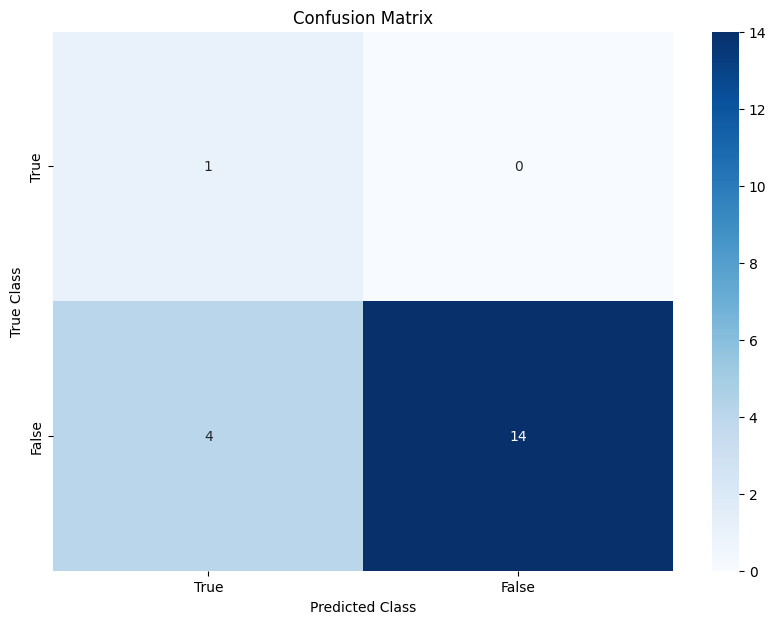

Classification Report:
              precision    recall  f1-score   support

       False       0.20      1.00      0.33         1
        True       1.00      0.78      0.88        18

    accuracy                           0.79        19
   macro avg       0.60      0.89      0.60        19
weighted avg       0.96      0.79      0.85        19



In [34]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(groundedness_df['ground_truth'], groundedness_df['outcome'])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=groundedness_df['ground_truth'].unique(), yticklabels=groundedness_df['ground_truth'].unique())
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(groundedness_df['ground_truth'], groundedness_df['outcome']))

# Determine Groundness using Semantic Similarity

In [35]:
evaluation_df = pd.read_csv("data/evaluation_data.csv")

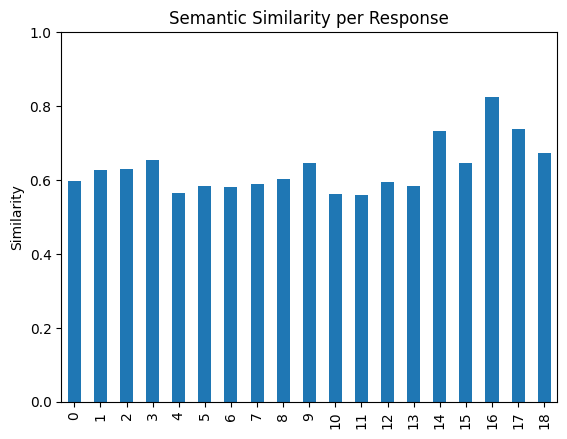

,user_input,is_grounded
0,What are the benefits of the Platinum Credit C...,True
1,Does the Platinum Credit Card offer travel ins...,True
2,What cashback percentage does the Gold Credit ...,True
3,Are there any additional protections included ...,True
4,What is the interest rate for the Everyday Sav...,True
5,Are there any conditions to earn the maximum i...,True
6,Does the Everyday Savings Account have any acc...,True
7,What is the interest rate for the 12-month Ter...,True
8,What is the minimum deposit required for the 2...,True
9,Are early withdrawals allowed for Term Deposits?,True


In [37]:

# Optional: Visualize
import matplotlib.pyplot as plt

evaluation_df['similarity'].plot(kind='bar', title='Semantic Similarity per Response', ylim=(0, 1))
plt.ylabel('Similarity')
plt.show()


threshold = 0.5
evaluation_df['is_grounded'] = evaluation_df['similarity'] >= threshold
evaluation_df[['user_input', 'is_grounded']]

# Summary:
# - If similarity < threshold → Potential hallucination → Needs to be flagged/reviewed.

In [38]:
evaluation_df['ground_truth'] = evaluation_df['is_grounded']
evaluation_df.to_csv("data/evaluation_data_GT.csv", index=False, encoding="utf-8-sig")

# Evaluate the similarity checking groundedness

In [39]:
similarity_groundedness_df = pd.read_csv("data/evaluation_data_GT.csv")

c:\Users\weixu\code\llm_guardrail\.venv\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


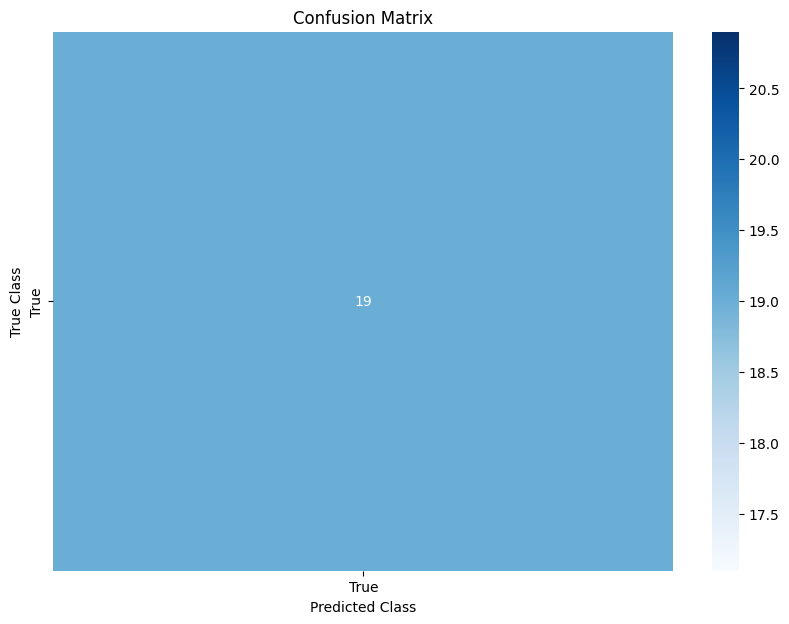

Classification Report:
              precision    recall  f1-score   support

        True       1.00      1.00      1.00        19

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



In [40]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(similarity_groundedness_df['ground_truth'], similarity_groundedness_df['is_grounded'])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=similarity_groundedness_df['ground_truth'].unique(), yticklabels=similarity_groundedness_df['ground_truth'].unique())
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(similarity_groundedness_df['ground_truth'], similarity_groundedness_df['is_grounded']))

# RAG performance evaluation for groundedness checking based on RAGAS



In [45]:
from ragas import EvaluationDataset
import ast
from ragas import evaluate

# read the evaluation data file and convert it to the format required by the evaluation function
evaluation_df = pd.read_csv("data/evaluation_data.csv")
#convert evaluatetion_df to json list
evaluation_list = evaluation_df.to_dict(orient='records')

# Convert the 'retrieved_contexts' field from string to list
for item in evaluation_list:
    if isinstance(item.get("retrieved_contexts"), str):
        try:
            item["retrieved_contexts"] = ast.literal_eval(item["retrieved_contexts"])
        except (ValueError, SyntaxError):
            print(f"Error converting retrieved_contexts for item: {item}")


evaluation_dataset = EvaluationDataset.from_list(evaluation_list)
# Run evaluation
metrics = [faithfulness, answer_relevancy, context_precision, context_recall, answer_correctness]
results = evaluate(evaluation_dataset, metrics)


Evaluating: 100%|██████████| 95/95 [00:49<00:00,  1.93it/s]


In [ ]:
print("=== Guardrail Evaluation Results ===")

# Add similarity scores
print("\n=== Similarity Scores ===")
print(evaluation_df[['user_input', 'similarity']])

# merge evaluation_df[['user_input', 'similarity']] with results.to_pandas() based on user_input
results_df = results.to_pandas()
results_df = results_df.merge(evaluation_df[['user_input', 'similarity']], on='user_input', how='left')

# save results to CSV
results_df.to_csv("rag_evaluation_results/evaluation_results.csv", index=False)
